# Install mamba and dependencies

In [ ]:
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=137750683 sha256=b264292652a34fb9dd0ce880a34a4407ba7256a3338388d056769ec29a4581c9
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm


In [ ]:
from mamba_ssm import Mamba
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *
from einops import rearrange

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [ ]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-10-01")
train_start_date = pd.to_datetime("2015-01-01")
out_cols = ['pct_change']
epochs = 25
batch_size = 256
d_model = 128 # number of input features to encoder layer
nhead = 32 # number of heads in multiheadattention
num_layers = 64 # number of encoder layers
dropout = 0.1 # dropout probability

# loading data
data_path = 'drive/MyDrive/data'
interval = '1d'
# companies = os.listdir(data_path)
companies = ['AAPL']
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

In [ ]:
def load_data(companies: list, ids: np.array, data_path: str, interval: str, train_start_date: pd.Timestamp, test_start_date: pd.Timestamp,
              out_cols: list, seq_size: int):
    company_stats = dict() # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    x_train = []
    x_test = []
    y_train = []
    y_test = []
    dates = []

    for co in tqdm(companies):
        files = os.listdir(os.path.join(data_path, co))
        for f in files: # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df['date'] = pd.to_datetime(df['date'])
        # remove blank column
        df = df.drop(columns=['Unnamed: 0'])
        # remove data before training start date
        df = df[df['date'] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, 'date')
        # add ticker column
        df_normed['ticker'] = ticker_to_num[co]

        cols = list(df_normed.columns)
        cols.append(cols.pop(cols.index('date'))) # move date to end of list since this will be the order of columns for output df

        # split each df into train and test timeframes
        df_train = df_normed[df_normed['date'] < test_start_date]
        df_test = df_normed[df_normed['date'] >= test_start_date]

        pred_dates = df_test['date'].iloc[seq_size:].tolist()
        dates.append(pred_dates)

        # drop unnecessary columns
        df_train = df_train.drop(columns=['date'])
        df_test = df_test.drop(columns=['date'])

        # store column indices for extracting output features we want
        feature_cols_idx = [list(df_train.columns).index(feature) for feature in out_cols]

        # convert to 2D numpy arrays of shape (-1, num_cols)
        train = df_train.to_numpy()
        test = df_test.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, train)
        for i in range(len(x)):
            x_train.append(x[i])
            y_train.append(y[i])
        x, y = to_sequences(seq_size, test)
        for i in range(len(x)):
            x_test.append(x[i])
            y_test.append(y[i])

        company_stats[co] = stat_dict

    indims = y_train[0].shape[0]
    outdims = len(out_cols)
    dates = [element for nestedlist in dates for element in nestedlist]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
    y_test = np.vstack(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, indims, outdims, dates, company_stats, num_to_ticker, ticker_to_num, feature_cols_idx


train_loader, test_loader, indims, outdims, dates, company_stats, num_to_ticker, ticker_to_num, feature_cols_idx = load_data(companies, ids, data_path, interval, train_start_date, test_start_date, out_cols, seq_size)

100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x


class MambaModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=512, seq_size=29, d_state=16, d_conv=4, expand=2, dropout=0.2):
        super(MambaModel, self).__init__()
        self.mamba = Mamba(d_model=input_dim, d_state=d_state, d_conv=d_conv, expand=expand)
        self.d1_nn = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(in_features=seq_size*input_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x):
        y = self.mamba(x)
        y = rearrange(y, 'B L F -> B (L F)') # flatten sequences
        y = self.d1_nn(y)
        y = self.fc1(y)
        return y

# model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
model = MambaModel(input_dim=indims, output_dim=outdims, seq_size=seq_size, d_state=32, d_conv=4, expand=4, dropout=0.1).to(device)

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    #### uncomment below to add early stopping ####

    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  4%|▍         | 1/25 [00:00<00:06,  3.74it/s]

Epoch 1/25, Train Loss: 1.0808, Validation Loss: 0.2809


  8%|▊         | 2/25 [00:00<00:06,  3.57it/s]

Epoch 2/25, Train Loss: 1.0804, Validation Loss: 0.2803


 12%|█▏        | 3/25 [00:00<00:06,  3.59it/s]

Epoch 3/25, Train Loss: 1.0439, Validation Loss: 0.2793


 16%|█▌        | 4/25 [00:01<00:05,  3.61it/s]

Epoch 4/25, Train Loss: 1.0237, Validation Loss: 0.2783


 20%|██        | 5/25 [00:01<00:05,  3.69it/s]

Epoch 5/25, Train Loss: 1.0355, Validation Loss: 0.2773


 24%|██▍       | 6/25 [00:01<00:05,  3.79it/s]

Epoch 6/25, Train Loss: 1.0481, Validation Loss: 0.2769


 28%|██▊       | 7/25 [00:01<00:04,  3.75it/s]

Epoch 7/25, Train Loss: 1.0130, Validation Loss: 0.2774


 32%|███▏      | 8/25 [00:02<00:04,  3.76it/s]

Epoch 8/25, Train Loss: 1.0300, Validation Loss: 0.2791


 36%|███▌      | 9/25 [00:02<00:04,  3.82it/s]

Epoch 9/25, Train Loss: 0.9867, Validation Loss: 0.2813


 40%|████      | 10/25 [00:02<00:03,  3.84it/s]

Epoch 10/25, Train Loss: 0.9567, Validation Loss: 0.2827


 44%|████▍     | 11/25 [00:02<00:03,  3.80it/s]

Epoch 11/25, Train Loss: 0.9422, Validation Loss: 0.2854


 48%|████▊     | 12/25 [00:03<00:03,  3.84it/s]

Epoch 12/25, Train Loss: 0.9500, Validation Loss: 0.2881


 52%|█████▏    | 13/25 [00:03<00:03,  3.89it/s]

Epoch 13/25, Train Loss: 0.8968, Validation Loss: 0.2881


 56%|█████▌    | 14/25 [00:03<00:02,  3.90it/s]

Epoch 14/25, Train Loss: 0.9800, Validation Loss: 0.2887


 60%|██████    | 15/25 [00:03<00:02,  3.80it/s]

Epoch 15/25, Train Loss: 0.9453, Validation Loss: 0.2879


 64%|██████▍   | 16/25 [00:04<00:02,  3.81it/s]

Epoch 16/25, Train Loss: 0.9426, Validation Loss: 0.2892


 68%|██████▊   | 17/25 [00:04<00:02,  3.85it/s]

Epoch 17/25, Train Loss: 0.9064, Validation Loss: 0.2906


 72%|███████▏  | 18/25 [00:04<00:01,  3.84it/s]

Epoch 18/25, Train Loss: 0.8994, Validation Loss: 0.2923


 76%|███████▌  | 19/25 [00:05<00:01,  3.80it/s]

Epoch 19/25, Train Loss: 0.9221, Validation Loss: 0.2918


 80%|████████  | 20/25 [00:05<00:01,  3.86it/s]

Epoch 20/25, Train Loss: 0.8765, Validation Loss: 0.2926


 84%|████████▍ | 21/25 [00:05<00:01,  3.61it/s]

Epoch 21/25, Train Loss: 0.8975, Validation Loss: 0.2933


 88%|████████▊ | 22/25 [00:05<00:00,  3.27it/s]

Epoch 22/25, Train Loss: 0.8965, Validation Loss: 0.2955


 92%|█████████▏| 23/25 [00:06<00:00,  3.05it/s]

Epoch 23/25, Train Loss: 0.8744, Validation Loss: 0.2976


 96%|█████████▌| 24/25 [00:06<00:00,  2.87it/s]

Epoch 24/25, Train Loss: 0.8853, Validation Loss: 0.2977


100%|██████████| 25/25 [00:07<00:00,  3.50it/s]

Epoch 25/25, Train Loss: 0.8647, Validation Loss: 0.2977


In [ ]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(outputs, batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
    df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])

df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
df_merged = pd.merge(df_pred, df_gt, 'inner')

1it [00:00, 18.94it/s]
<ipython-input-82-058d91873505>:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
<ipython-input-82-058d91873505>:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])


In [ ]:
# df_merged['new_pct_change_pred'] = df_merged['pct_change_pred'].pct_change()
# df_merged = df_merged.dropna()
df_merged.head()

,pct_change_pred,ticker,date,pct_change_gt
0,0.000009,AAPL,2023-11-13,-0.008584
1,-0.000313,AAPL,2023-11-14,0.014286
2,-0.001234,AAPL,2023-11-15,0.003041
3,-0.001237,AAPL,2023-11-16,0.009042
4,-0.002534,AAPL,2023-11-17,-0.000105


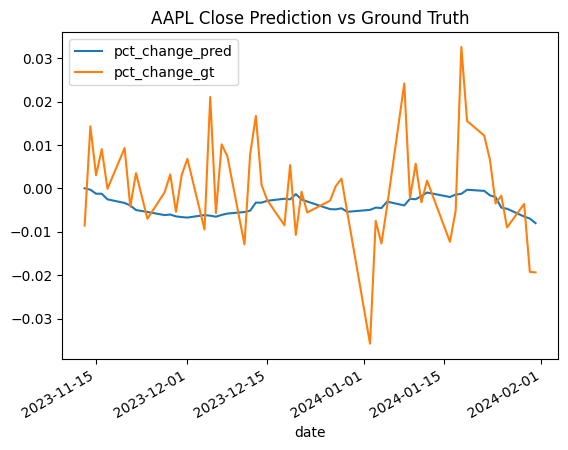

In [ ]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"AAPL Close Prediction vs Ground Truth")
plt.show()

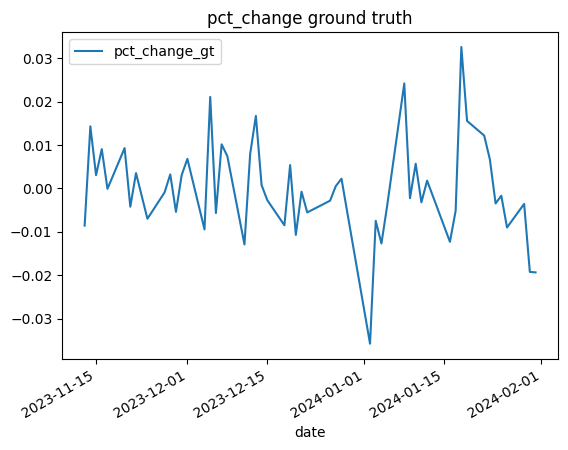

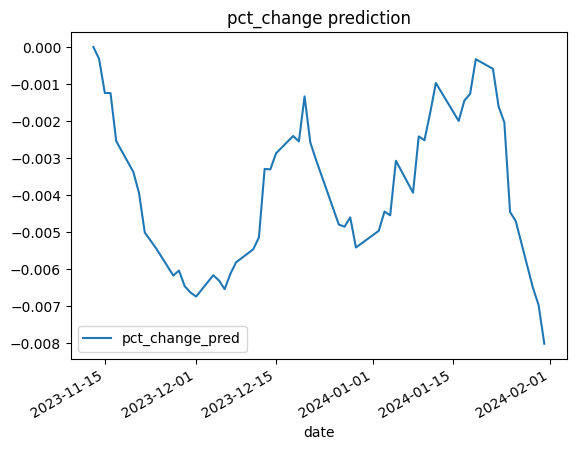

In [ ]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_gt')
plt.title("pct_change ground truth")
plt.show()
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_pred')
plt.title("pct_change prediction")
plt.show()

In [ ]:
accuracy_metrics = dict()
for i in tqdm(range(len(companies))):
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    accuracy_metrics[companies[i]] = directional_accuracy_pct_change(gt_rows, pred_rows)

accuracy_metrics


100%|██████████| 1/1 [00:00<00:00, 464.95it/s]


{'AAPL': 0.5051546391752577}